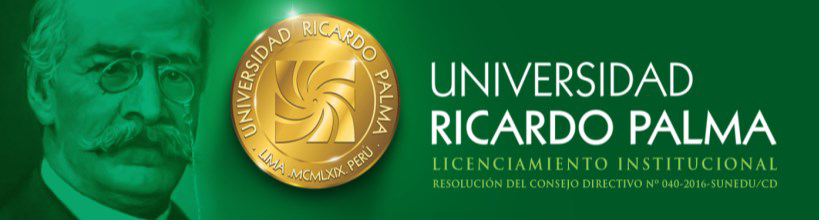

# Detección de delitos

In [1]:
# Instalar YOLOv8 (Ultralytics)
!pip install ultralytics

# Dependencias adicionales
!pip install roboflow
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
# Librerías necesarias
import os
import shutil
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO

import random
from sklearn.model_selection import train_test_split

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Descargar datos desde Roboflow

rf = Roboflow(api_key="4FODTx7cnvUVaiWDx5dI")

project_robo_mano_armada = rf.workspace("revisiondata").project("robo_a_mano_armada_sa")
dataset_robo_mano_armada  = project_robo_mano_armada.version(6).download("yolov8")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Robo_a_mano_armada_sa-6 in yolov8:: 100%|██████████| 3394/3394 [00:00<00:00, 4301.98it/s]


In [4]:

project_robo_en_tienda = rf.workspace("revisiondata").project("robo_en_tienda")
dataset_robo_en_tienda = project_robo_en_tienda.version(7).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Robo_en_Tienda-7 in yolov8:: 100%|██████████| 2128/2128 [00:00<00:00, 4358.32it/s]


In [5]:

project_vandalismo = rf.workspace("revisiondata").project("vandalismo-fpszl")
dataset_vandalismo = project_vandalismo.version(11).download("yolov8")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vandalismo-11 in yolov8:: 100%|██████████| 1964/1964 [00:00<00:00, 7359.58it/s]


In [6]:
project_actividad_normal = rf.workspace("revisiondata").project("actividad_normal")
dataset_actividad_normal = project_actividad_normal.version(7).download("yolov8")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Actividad_Normal-7 in yolov8:: 100%|██████████| 1912/1912 [00:00<00:00, 6108.98it/s]


In [7]:
print(f"Robo_mano_armada: {dataset_robo_mano_armada.location}")
print(f"Robo_en_tienda: {dataset_robo_en_tienda.location}")
print(f"Vandalismo: {dataset_vandalismo.location}")
print(f"Actividad_normal: {dataset_actividad_normal.location}")
#print(f"Arma: {dataset_arma.location}")

Robo_mano_armada: /content/Robo_a_mano_armada_sa-6
Robo_en_tienda: /content/Robo_en_Tienda-7
Vandalismo: /content/Vandalismo-11
Actividad_normal: /content/Actividad_Normal-7


In [8]:
def verificar_estructura(dataset_path, nombre):
    print(f"\nVerificando {nombre}:")
    print(f"Ruta: {dataset_path}")

    train_img = os.path.join(dataset_path, 'train', 'images')
    train_lbl = os.path.join(dataset_path, 'train', 'labels')
    valid_img = os.path.join(dataset_path, 'valid', 'images')
    test_img = os.path.join(dataset_path, 'test', 'images')

    if os.path.exists(train_img):
        num_train_img = len([f for f in os.listdir(train_img) if f.endswith(('.jpg', '.png'))])
        print(f"Train imágenes: {num_train_img}")

    if os.path.exists(train_lbl):
        num_train_lbl = len([f for f in os.listdir(train_lbl) if f.endswith('.txt')])
        print(f"Train etiquetas: {num_train_lbl}")

    if os.path.exists(valid_img):
        num_valid = len([f for f in os.listdir(valid_img) if f.endswith(('.jpg', '.png'))])
        print(f"Valid imágenes: {num_valid}")
    else:
        print("Valid: No existe")

    if os.path.exists(test_img):
        num_test = len([f for f in os.listdir(test_img) if f.endswith(('.jpg', '.png'))])
        print(f"Test imágenes: {num_test}")
    else:
        print("Test: No existe")


In [9]:
verificar_estructura(dataset_robo_mano_armada.location, "Robo_mano_armada")
verificar_estructura(dataset_robo_en_tienda.location, "Robo_en_tienda")
verificar_estructura(dataset_vandalismo.location, "Vandalismo")
verificar_estructura(dataset_actividad_normal.location, "Actividad_normal")


Verificando Robo_mano_armada:
Ruta: /content/Robo_a_mano_armada_sa-6
Train imágenes: 1694
Train etiquetas: 1694
Valid: No existe
Test: No existe

Verificando Robo_en_tienda:
Ruta: /content/Robo_en_Tienda-7
Train imágenes: 1061
Train etiquetas: 1061
Valid: No existe
Test: No existe

Verificando Vandalismo:
Ruta: /content/Vandalismo-11
Train imágenes: 979
Train etiquetas: 979
Valid: No existe
Test: No existe

Verificando Actividad_normal:
Ruta: /content/Actividad_Normal-7
Train imágenes: 953
Train etiquetas: 953
Valid: No existe
Test: No existe


In [10]:
def verificar_orden_archivos(dataset_path, nombre):
    train_img = os.path.join(dataset_path, 'train', 'images')

    if os.path.exists(train_img):
        archivos = [f for f in os.listdir(train_img) if f.endswith(('.jpg', '.png'))]
        archivos.sort()

        print(f"\n{nombre} - Primeros 10 archivos:")
        for i, archivo in enumerate(archivos[:10]):
            print(f"{i+1}: {archivo}")

        print(f"\nTotal archivos: {len(archivos)}")
        return archivos
    return []


In [11]:
archivos_robo_mano_armada = verificar_orden_archivos(dataset_robo_mano_armada.location, "Robo_mano_armada")
archivos_robo_en_tienda = verificar_orden_archivos(dataset_robo_en_tienda.location, "Robo_en_tienda")
archivos_vandalismo = verificar_orden_archivos(dataset_vandalismo.location, "Vandalismo")
archivos_actividad_normal = verificar_orden_archivos(dataset_actividad_normal.location, "Actividad_normal")


Robo_mano_armada - Primeros 10 archivos:
1: Robbery002_x264_000083_jpg.rf.4cc0b141bfb6a11cf5f13660da27f7f3.jpg
2: Robbery002_x264_000084_jpg.rf.338d54b4f30207c5e3f5bb2a2236fab6.jpg
3: Robbery002_x264_000085_jpg.rf.2fddb3847fd821a5bf15fc44c2182732.jpg
4: Robbery002_x264_000086_jpg.rf.d1e601cf0c370fd0dfdf014be2c8511b.jpg
5: Robbery002_x264_000087_jpg.rf.840bcffbb1ee87195dd1ab9b25811b33.jpg
6: Robbery002_x264_000088_jpg.rf.77e8ed683b360640e8dccc739061236c.jpg
7: Robbery002_x264_000089_jpg.rf.33638deef5d6bd6a1c5a9ccd08f9cff2.jpg
8: Robbery002_x264_000090_jpg.rf.631f6805dd2eec5c23187a5fa44bbfd3.jpg
9: Robbery002_x264_000091_jpg.rf.b2dbce7adf4ab58e2300dce3c574b77f.jpg
10: Robbery002_x264_000092_jpg.rf.490a728c57b80b12f1d6572d60653277.jpg

Total archivos: 1694

Robo_en_tienda - Primeros 10 archivos:
1: Shoplifting001_x264_000001_jpg.rf.69f1b16654decfdbae321cebe269cbe3.jpg
2: Shoplifting001_x264_000002_jpg.rf.5d5915ec5e5792d875dc33564cbbb516.jpg
3: Shoplifting001_x264_000003_jpg.rf.2b972cd63e

In [12]:
def dividir_datos_ordenados(archivos, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
    total = len(archivos)

    train_end = int(total * train_ratio)
    valid_end = int(total * (train_ratio + valid_ratio))

    train_files = archivos[:train_end]
    valid_files = archivos[train_end:valid_end]
    test_files = archivos[valid_end:]

    print(f"División ordenada:")
    print(f"Train: {len(train_files)} archivos")
    print(f"Valid: {len(valid_files)} archivos")
    print(f"Test: {len(test_files)} archivos")

    return train_files, valid_files, test_files

In [13]:
train_robo_mano_armada, valid_robo_mano_armada, test_robo_mano_armada = dividir_datos_ordenados(archivos_robo_mano_armada)
train_robo_en_tienda, valid_robo_en_tienda, test_robo_en_tienda = dividir_datos_ordenados(archivos_robo_en_tienda)
train_vandalismo, valid_vandalismo, test_vandalismo = dividir_datos_ordenados(archivos_vandalismo)
train_actividad_normal, valid_actividad_normal, test_actividad_normal = dividir_datos_ordenados(archivos_actividad_normal)

División ordenada:
Train: 1185 archivos
Valid: 339 archivos
Test: 170 archivos
División ordenada:
Train: 742 archivos
Valid: 212 archivos
Test: 107 archivos
División ordenada:
Train: 685 archivos
Valid: 196 archivos
Test: 98 archivos
División ordenada:
Train: 667 archivos
Valid: 190 archivos
Test: 96 archivos


In [14]:
def crear_estructura_unificada():
    splits = ['train', 'valid', 'test']
    tipos = ['images', 'labels']

    for split in splits:
        for tipo in tipos:
            carpeta = f'Actividades_Unified/{split}/{tipo}'
            os.makedirs(carpeta, exist_ok=True)


In [15]:
crear_estructura_unificada()

In [16]:
def leer_clases_yaml(yaml_path):
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    return config['names']

def convertir_a_dict(clases):
    if isinstance(clases, list):
        return {i: nombre for i, nombre in enumerate(clases)}
    return clases

clases_robo_mano_armada = convertir_a_dict(leer_clases_yaml(os.path.join(dataset_robo_mano_armada.location, 'data.yaml')))
clases_robo_en_tienda = convertir_a_dict(leer_clases_yaml(os.path.join(dataset_robo_en_tienda.location, 'data.yaml')))
clases_vandalismo = convertir_a_dict(leer_clases_yaml(os.path.join(dataset_vandalismo.location, 'data.yaml')))
clases_actividad_normal = convertir_a_dict(leer_clases_yaml(os.path.join(dataset_actividad_normal.location, 'data.yaml')))

print("Clases robo_mano_armada:", clases_robo_mano_armada)
print("Clases robo_en_tienda:", clases_robo_en_tienda)
print("Clases vandalismo:", clases_vandalismo)
print("Clases actividad_normal:", clases_actividad_normal)

Clases robo_mano_armada: {0: 'victima', 1: 'victimario'}
Clases robo_en_tienda: {0: 'victimario'}
Clases vandalismo: {0: 'grafiti', 1: 'victimario'}
Clases actividad_normal: {0: 'persona'}


In [17]:
clases_unificadas = {}
mapeo_robo_mano_armada = {}
mapeo_robo_en_tienda = {}
mapeo_vandalismo = {}
mapeo_actividad_normal = {}

indice_actual = 0

for i, nombre in clases_robo_mano_armada.items():
    clases_unificadas[indice_actual] = f"robo_mano_armada_{nombre}"
    mapeo_robo_mano_armada[i] = indice_actual
    indice_actual += 1

for i, nombre in clases_robo_en_tienda.items():
    clases_unificadas[indice_actual] = f"robo_en_tienda_{nombre}"
    mapeo_robo_en_tienda[i] = indice_actual
    indice_actual += 1

for i, nombre in clases_vandalismo.items():
    clases_unificadas[indice_actual] = f"vandalismo_{nombre}"
    mapeo_vandalismo[i] = indice_actual
    indice_actual += 1

for i, nombre in clases_actividad_normal.items():
    clases_unificadas[indice_actual] = f"actividad_normal_{nombre}"
    mapeo_actividad_normal[i] = indice_actual
    indice_actual += 1

print("\nClases unificadas:")
for i, nombre in clases_unificadas.items():
    print(f"{i}: {nombre}")


Clases unificadas:
0: robo_mano_armada_victima
1: robo_mano_armada_victimario
2: robo_en_tienda_victimario
3: vandalismo_grafiti
4: vandalismo_victimario
5: actividad_normal_persona


In [18]:
def actualizar_etiquetas(archivo_origen, archivo_destino, mapeo_clases):
    with open(archivo_origen, 'r') as f:
        lineas = f.readlines()

    with open(archivo_destino, 'w') as f:
        for linea in lineas:
            partes = linea.strip().split()
            if len(partes) > 0:
                clase_original = int(partes[0])
                if clase_original in mapeo_clases:
                    clase_nueva = mapeo_clases[clase_original]
                    partes[0] = str(clase_nueva)
                    f.write(' '.join(partes) + '\n')

def copiar_archivos_divididos(dataset_path, prefijo, mapeo_clases, train_files, valid_files, test_files):
    original_train_img = os.path.join(dataset_path, 'train', 'images')
    original_train_lbl = os.path.join(dataset_path, 'train', 'labels')

    divisiones = {
        'train': train_files,
        'valid': valid_files,
        'test': test_files
    }

    for split, archivos in divisiones.items():
        for archivo in archivos:
            # Copiar imagen
            src_img = os.path.join(original_train_img, archivo)
            dst_img = f'Actividades_Unified/{split}/images/{prefijo}_{archivo}'
            if os.path.exists(src_img):
                shutil.copy2(src_img, dst_img)

            # Copiar etiqueta
            lbl_name = archivo.replace('.jpg', '.txt').replace('.png', '.txt')
            src_lbl = os.path.join(original_train_lbl, lbl_name)
            dst_lbl = f'Actividades_Unified/{split}/labels/{prefijo}_{lbl_name}'
            if os.path.exists(src_lbl):
                actualizar_etiquetas(src_lbl, dst_lbl, mapeo_clases)


In [19]:

print("Copiando Robo a mano armada...")
copiar_archivos_divididos(dataset_robo_mano_armada.location, 'robo_mano_armada', mapeo_robo_mano_armada,
                         train_robo_mano_armada, valid_robo_mano_armada, test_robo_mano_armada)


Copiando Robo a mano armada...


In [20]:

print("Copiando robo_en_tienda...")
copiar_archivos_divididos(dataset_robo_en_tienda.location, 'robo_en_tienda', mapeo_robo_en_tienda,
                         train_robo_en_tienda, valid_robo_en_tienda, test_robo_en_tienda)


Copiando robo_en_tienda...


In [21]:

print("Copiando vandalismo...")
copiar_archivos_divididos(dataset_vandalismo.location, 'vandalismo', mapeo_vandalismo,
                         train_vandalismo, valid_vandalismo, test_vandalismo)

Copiando vandalismo...


In [22]:

print("Copiando actividad_normal...")
copiar_archivos_divididos(dataset_actividad_normal.location, 'actividad_normal', mapeo_actividad_normal,
                         train_actividad_normal, valid_actividad_normal, test_actividad_normal)

Copiando actividad_normal...


In [23]:
def verificar_datos_unificados():
    splits = ['train', 'valid', 'test']

    for split in splits:
        img_path = f'Actividades_Unified/{split}/images'
        lbl_path = f'Actividades_Unified/{split}/labels'

        num_img = len([f for f in os.listdir(img_path) if f.endswith(('.jpg', '.png'))])
        num_lbl = len([f for f in os.listdir(lbl_path) if f.endswith('.txt')])

        print(f"{split}: {num_img} imágenes, {num_lbl} etiquetas")

verificar_datos_unificados()

train: 3279 imágenes, 3279 etiquetas
valid: 937 imágenes, 937 etiquetas
test: 471 imágenes, 471 etiquetas


In [24]:
def visualizar_muestra_split(split='train', num_muestras=3):
    # Definimos las clases por categoría
    clases_robo_mano_armada = ['victima', 'victimario']
    clases_robo_en_tienda = ['victimario']
    clases_vandalismo = ['graffiti', 'victimario']
    clases_actividad_normal = ['persona']

    total_clases = (
        clases_robo_mano_armada +
        clases_robo_en_tienda +
        clases_vandalismo +
        clases_actividad_normal
    )

    idx_robo = len(clases_robo_mano_armada)
    idx_tienda = idx_robo + len(clases_robo_en_tienda)
    idx_vandalismo = idx_tienda + len(clases_vandalismo)
    # actividad_normal ocupa el resto

    img_path = f'Actividades_Unified/{split}/images'
    lbl_path = f'Actividades_Unified/{split}/labels'

    archivos = [f for f in os.listdir(img_path) if f.endswith(('.jpg', '.png'))]
    archivos.sort()
    muestras = archivos[:num_muestras]

    fig, axes = plt.subplots(1, len(muestras), figsize=(15, 5))
    if len(muestras) == 1:
        axes = [axes]

    for i, img_name in enumerate(muestras):
        img_file = os.path.join(img_path, img_name)
        image = cv2.imread(img_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        lbl_file = os.path.join(lbl_path, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

        if os.path.exists(lbl_file):
            with open(lbl_file, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    clase = int(parts[0])
                    x_center, y_center, w, h = map(float, parts[1:])

                    # Convertir a píxeles
                    x1 = int((x_center - w / 2) * width)
                    y1 = int((y_center - h / 2) * height)
                    x2 = int((x_center + w / 2) * width)
                    y2 = int((y_center + h / 2) * height)

                    # Colores por categoría
                    if clase < idx_robo:
                        color = (255, 0, 0)      # 🔴 robo mano armada
                    elif clase < idx_tienda:
                        color = (0, 255, 0)      # 🟢 robo tienda
                    elif clase < idx_vandalismo:
                        color = (0, 0, 255)      # 🔵 vandalismo
                    else:
                        color = (255, 255, 0)    # 🟡 actividad normal

                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                    # Mostrar nombre de la clase (opcional)
                    nombre_clase = total_clases[clase] if clase < len(total_clases) else f"class_{clase}"
                    cv2.putText(image, nombre_clase, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        axes[i].imshow(image)
        axes[i].set_title(f"{split}: {img_name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Muestras Train:


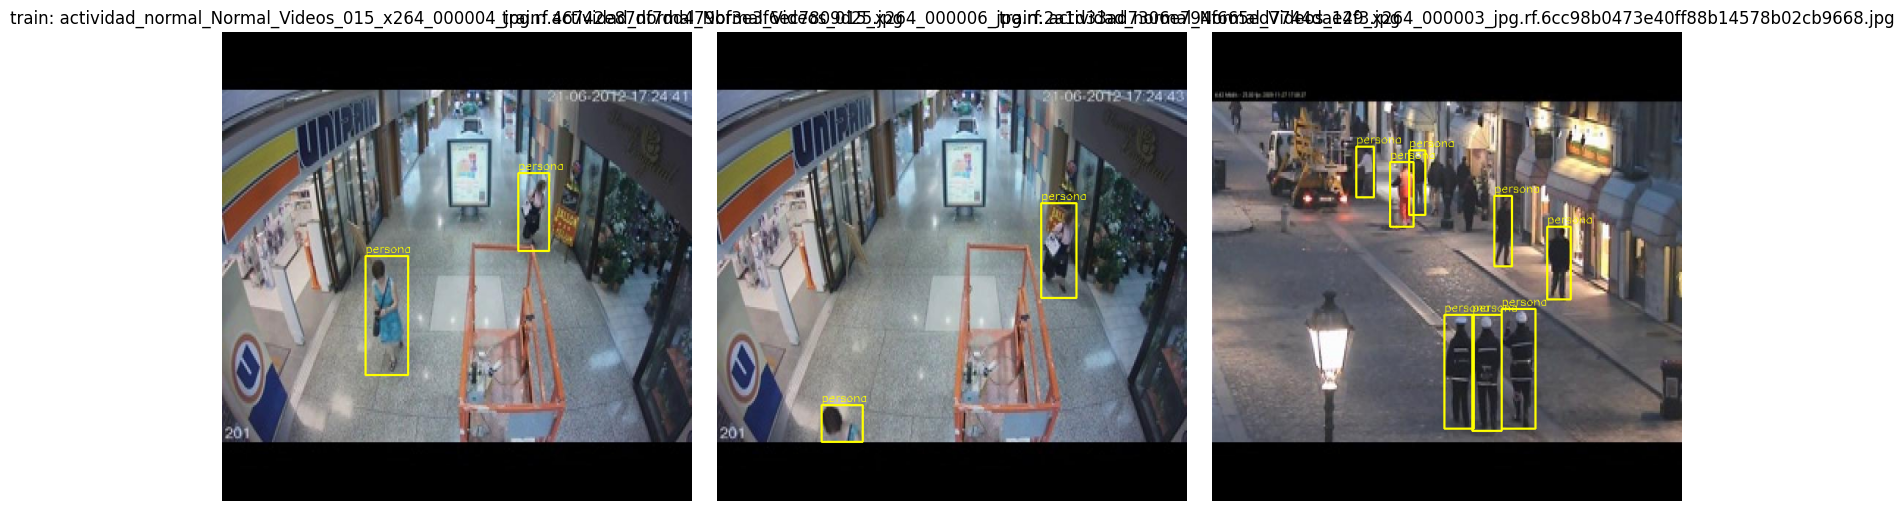

In [25]:
print("Muestras Train:")
visualizar_muestra_split('train')



Muestras Valid:


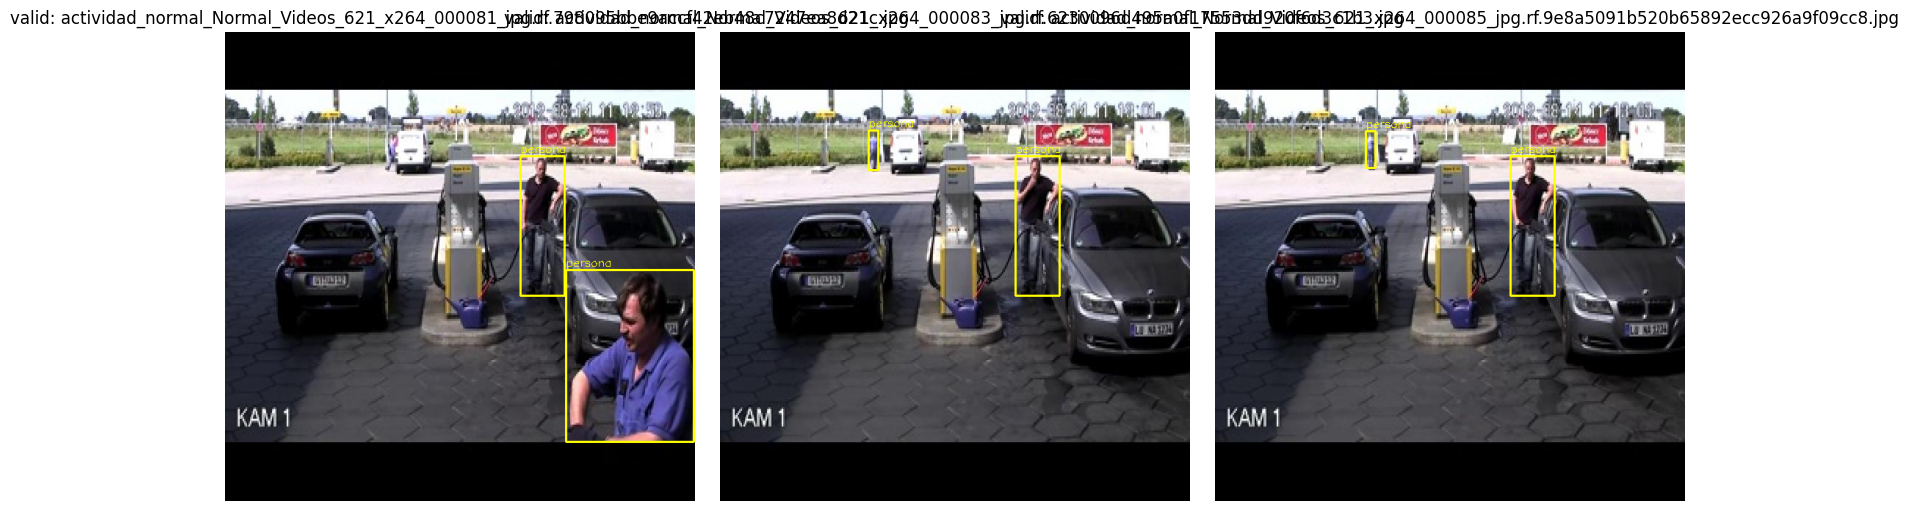

In [26]:
print("Muestras Valid:")
visualizar_muestra_split('valid')



Muestras Valid:


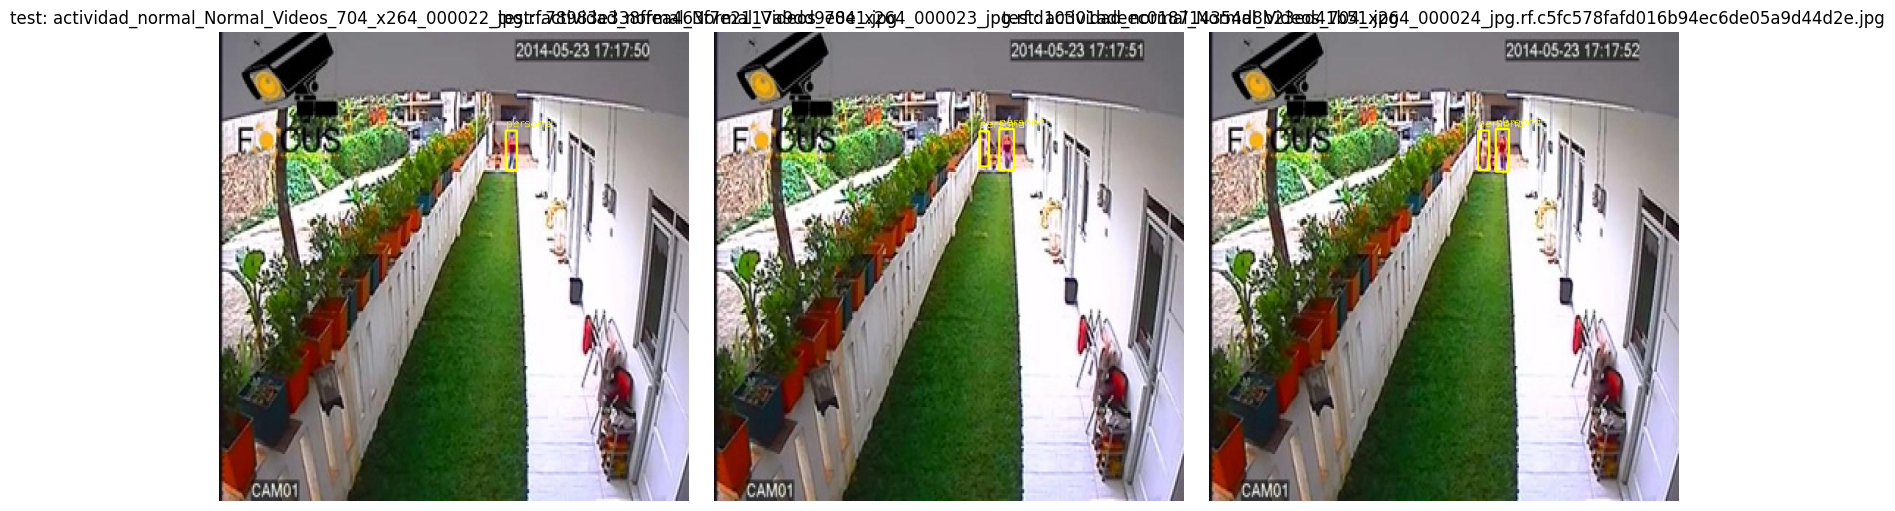

In [27]:
print("Muestras Valid:")
visualizar_muestra_split('test')



In [28]:
verificar_datos_unificados()

train: 3279 imágenes, 3279 etiquetas
valid: 937 imágenes, 937 etiquetas
test: 471 imágenes, 471 etiquetas


In [29]:
config_unificado = {
    'path': './Actividades_Unified',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': clases_unificadas,
    'nc': len(clases_unificadas)
}

with open('actividades_unified.yaml', 'w') as f:
    yaml.dump(config_unificado, f, default_flow_style=False)

print(f"YAML creado con {len(clases_unificadas)} clases")

YAML creado con 6 clases


## Información general

In [31]:
# Cantidad de imágenes
verificar_datos_unificados()

train: 3279 imágenes, 3279 etiquetas
valid: 937 imágenes, 937 etiquetas
test: 471 imágenes, 471 etiquetas


In [30]:
# Mostrar contenido del YAML
with open('actividades_unified.yaml', 'r') as f:
    print("\nContenido del YAML:")
    print(f.read())


Contenido del YAML:
names:
  0: robo_mano_armada_victima
  1: robo_mano_armada_victimario
  2: robo_en_tienda_victimario
  3: vandalismo_grafiti
  4: vandalismo_victimario
  5: actividad_normal_persona
nc: 6
path: ./Actividades_Unified
test: test/images
train: train/images
val: valid/images



In [32]:
# Numero de imagenes por clase
from collections import Counter
import os

labels_path = '/content/Actividades_Unified/train/labels'
clases = Counter()

for file in os.listdir(labels_path):
    with open(os.path.join(labels_path, file), 'r') as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            clases[class_id] += 1

print("Instancias por clase en entrenamiento:")
for clase, count in sorted(clases.items()):
    print(f"Clase {clase}: {count} instancias")

Instancias por clase en entrenamiento:
Clase 0: 939 instancias
Clase 1: 1184 instancias
Clase 2: 1109 instancias
Clase 3: 1229 instancias
Clase 4: 397 instancias
Clase 5: 2343 instancias


## EDA (Análisis Exploratorio de Datos)

In [39]:
# Analizar imágenes de entrenamiento
from pathlib import Path
train_images_path = Path('/content/Actividades_Unified/train/images')
train_stats = analyze_images(train_images_path, "Entrenamiento")


In [42]:
val_images_path = Path('/content/Actividades_Unified/valid/images')
val_stats = analyze_images(val_images_path, "Validación")

In [43]:
test_images_path = Path('/content/Actividades_Unified/valid/images')
test_stats = analyze_images(test_images_path, "Prueba")

In [92]:
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_images_per_class_pie(label_dir, class_names=None, title="Imágenes por Clase"):
    """
    Muestra un gráfico de pastel con el número de imágenes que contienen al menos
    una instancia de cada clase.
    """
    class_to_images = defaultdict(set)  # clase → conjunto de archivos .txt

    label_files = list(Path(label_dir).glob("*.txt"))

    for file in label_files:
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    class_to_images[class_id].add(file.name)

    # Contar imágenes únicas por clase
    class_counts = {cls: len(images) for cls, images in class_to_images.items()}

    # Preparar datos para el gráfico
    labels = [class_names[cls] if class_names else f"Clase {cls}" for cls in class_counts.keys()]
    sizes = list(class_counts.values())

    # Gráfico de pastel
    colors = ['#AEDFF7', '#FFC3A0', '#C4F0C5', '#F7D8BA', '#E2CFEA', '#F2F0A1']
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors[:len(labels)],
            autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.show()

In [89]:
def generate_annotation_summary(label_dir, class_names=None):
    """
    Muestra un resumen con:
    - Total de archivos de anotación (.txt)
    - Frecuencia de objetos por clase
    """
    from collections import Counter
    label_files = list(Path(label_dir).glob("*.txt"))
    total_files = len(label_files)

    class_counter = Counter()

    for file in label_files:
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    class_counter[class_id] += 1

    print(f"📄 Total de archivos de anotaciones: {total_files}")
    print("📌 Frecuencia por clase:")
    for cls_id in sorted(class_counter.keys()):
        name = class_names[cls_id] if class_names and cls_id < len(class_names) else f"Clase {cls_id}"
        print(f"{name}: {class_counter[cls_id]} objetos")

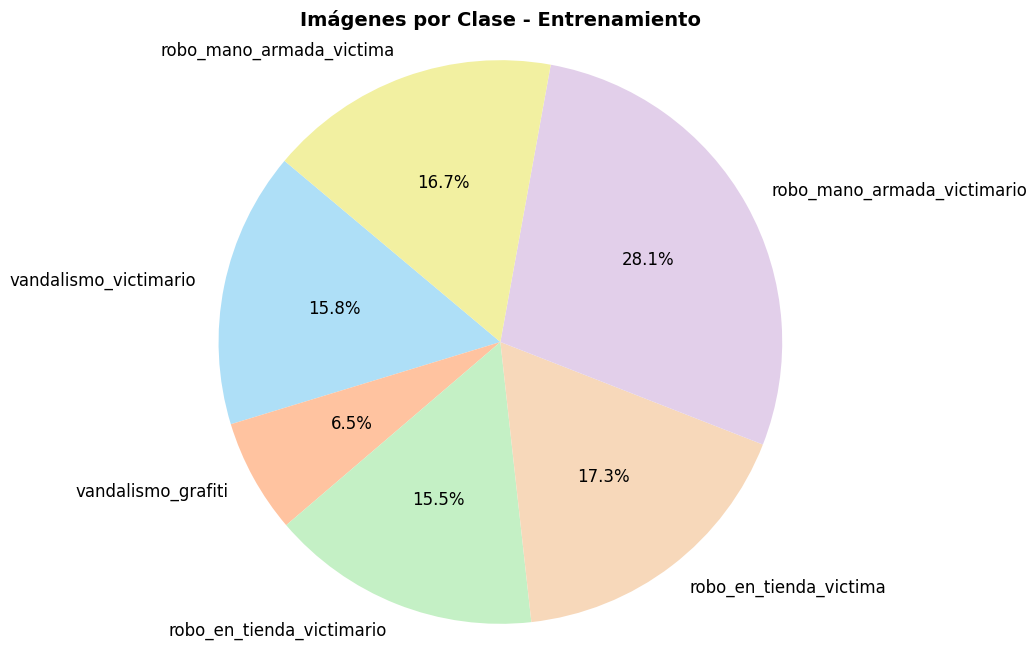

In [93]:
# Define tu ruta de etiquetas (por ejemplo, train)
train_labels_dir = '/content/Actividades_Unified/train/labels'

# (Opcional) Lista de nombres de clases
class_names = [
    "robo_mano_armada_victima",
    "robo_mano_armada_victimario",
    "robo_en_tienda_victima",
    "robo_en_tienda_victimario",
    "vandalismo_grafiti",
    "vandalismo_victimario"
]

# Llamar a la función
plot_images_per_class_pie(train_labels_dir, class_names, title="Imágenes por Clase - Entrenamiento")


In [91]:
# Nombres de clase opcionales
class_names = [
    "robo_mano_armada_victima",
    "robo_mano_armada_victimario",
    "robo_en_tienda_victima",
    "robo_en_tienda_victimario",
    "vandalismo_grafiti",
    "vandalismo_victimario"
]

generate_annotation_summary(train_labels_dir, class_names)

📄 Total de archivos de anotaciones: 3279
📌 Frecuencia por clase:
robo_mano_armada_victima: 939 objetos
robo_mano_armada_victimario: 1184 objetos
robo_en_tienda_victima: 1109 objetos
robo_en_tienda_victimario: 1229 objetos
vandalismo_grafiti: 397 objetos
vandalismo_victimario: 2343 objetos


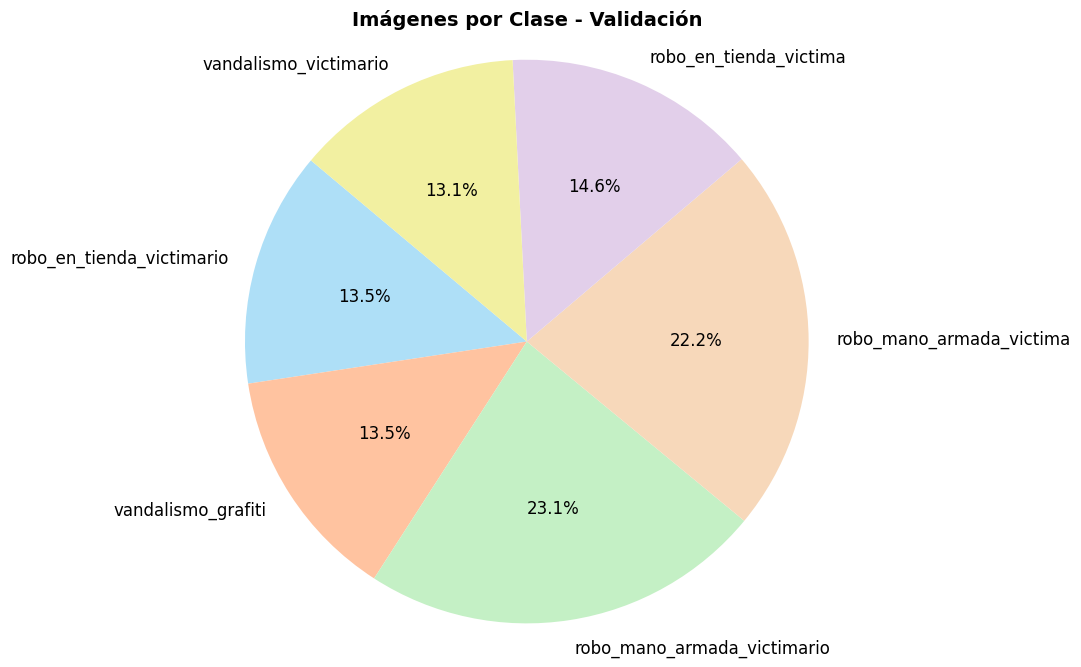

In [95]:
# Llamar a la función
# Define tu ruta de etiquetas (por ejemplo, train)
valid_labels_dir = '/content/Actividades_Unified/valid/labels'
plot_images_per_class_pie(train_labels_dir, class_names, title="Imágenes por Clase - Validación")

In [96]:
generate_annotation_summary(valid_labels_dir, class_names)

📄 Total de archivos de anotaciones: 937
📌 Frecuencia por clase:
robo_mano_armada_victima: 612 objetos
robo_mano_armada_victimario: 336 objetos
robo_en_tienda_victima: 417 objetos
robo_en_tienda_victimario: 196 objetos
vandalismo_grafiti: 196 objetos
vandalismo_victimario: 557 objetos


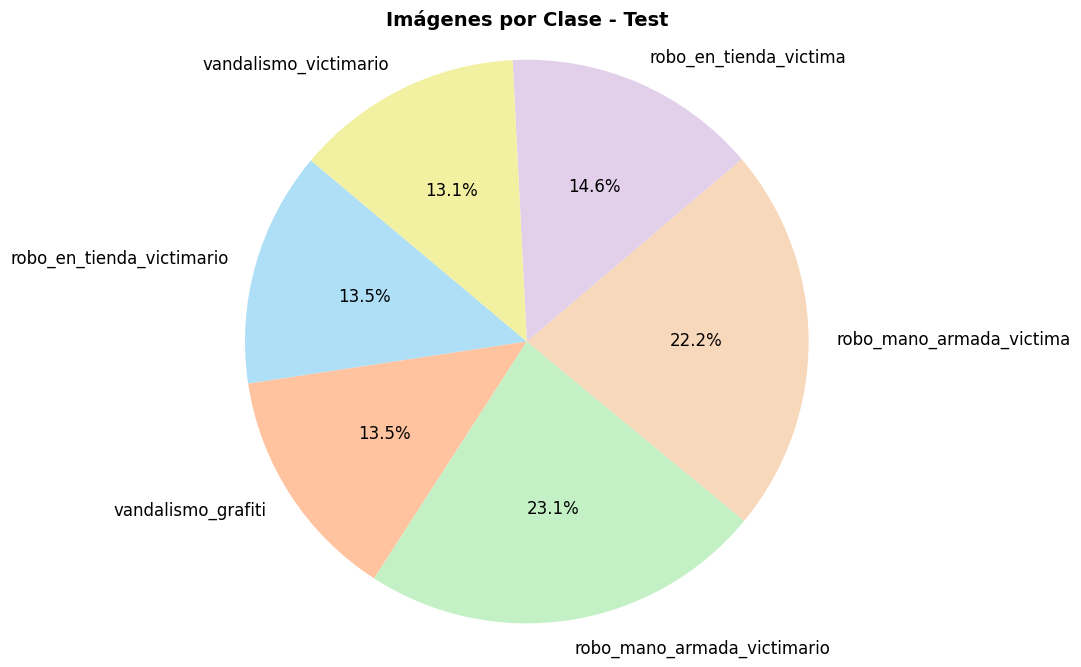

In [99]:
# Llamar a la función
# Define tu ruta de etiquetas (por ejemplo, train)
test_labels_dir = '/content/Actividades_Unified/test/labels'
plot_images_per_class_pie(train_labels_dir, class_names, title="Imágenes por Clase - Test")

In [100]:
generate_annotation_summary(test_labels_dir, class_names)

📄 Total de archivos de anotaciones: 471
📌 Frecuencia por clase:
robo_mano_armada_victima: 42 objetos
robo_mano_armada_victimario: 170 objetos
robo_en_tienda_victima: 129 objetos
robo_en_tienda_victimario: 98 objetos
vandalismo_grafiti: 64 objetos
vandalismo_victimario: 566 objetos


In [56]:
from PIL import Image
import os

def analyze_image_properties(images_dir):
    widths = []
    heights = []
    file_sizes = []
    aspect_ratios = []
    formats = Counter()

    image_files = list(Path(images_dir).glob("*.*"))

    for img_path in image_files:
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
                aspect_ratios.append(width / height if height != 0 else 0)
                formats[img.format] += 1
            file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
        except Exception as e:
            print(f"Error con {img_path}: {e}")
            continue

    return {
        "widths": widths,
        "heights": heights,
        "file_sizes": file_sizes,
        "aspect_ratios": aspect_ratios,
        "formats": formats
    }

def plot_image_properties(stats_dict, title_prefix="Train Images"):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"{title_prefix} - Propiedades de Imágenes", fontsize=16, fontweight='bold')

    # Distribución de anchos
    axes[0, 0].hist(stats_dict['widths'], bins=30, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribución de Anchos (pixeles)')
    axes[0, 0].set_xlabel('Ancho')
    axes[0, 0].set_ylabel('Frecuencia')

    # Distribución de alturas
    axes[0, 1].hist(stats_dict['heights'], bins=30, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Distribución de Alturas (pixeles)')
    axes[0, 1].set_xlabel('Alto')
    axes[0, 1].set_ylabel('Frecuencia')

    # Distribución de tamaños
    axes[0, 2].hist(stats_dict['file_sizes'], bins=30, color='salmon', edgecolor='black')
    axes[0, 2].set_title('Distribución de Tamaños de Archivo (KB)')
    axes[0, 2].set_xlabel('Tamaño (KB)')
    axes[0, 2].set_ylabel('Frecuencia')

    # Relación de aspecto
    axes[1, 0].hist(stats_dict['aspect_ratios'], bins=30, color='gold', edgecolor='black')
    axes[1, 0].set_title('Relación de Aspecto (Ancho / Alto)')
    axes[1, 0].set_xlabel('Relación')
    axes[1, 0].set_ylabel('Frecuencia')

    # Dispersión Ancho vs Alto
    axes[1, 1].scatter(stats_dict['widths'], stats_dict['heights'], alpha=0.5, color='mediumpurple', s=10)
    axes[1, 1].set_title('Relación Ancho vs Alto (pixeles)')
    axes[1, 1].set_xlabel('Ancho')
    axes[1, 1].set_ylabel('Alto')

    # Tipos de formato
    if stats_dict['formats']:
        labels = list(stats_dict['formats'].keys())
        values = list(stats_dict['formats'].values())
        axes[1, 2].pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
        axes[1, 2].set_title('Distribución de Formatos de Archivo')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


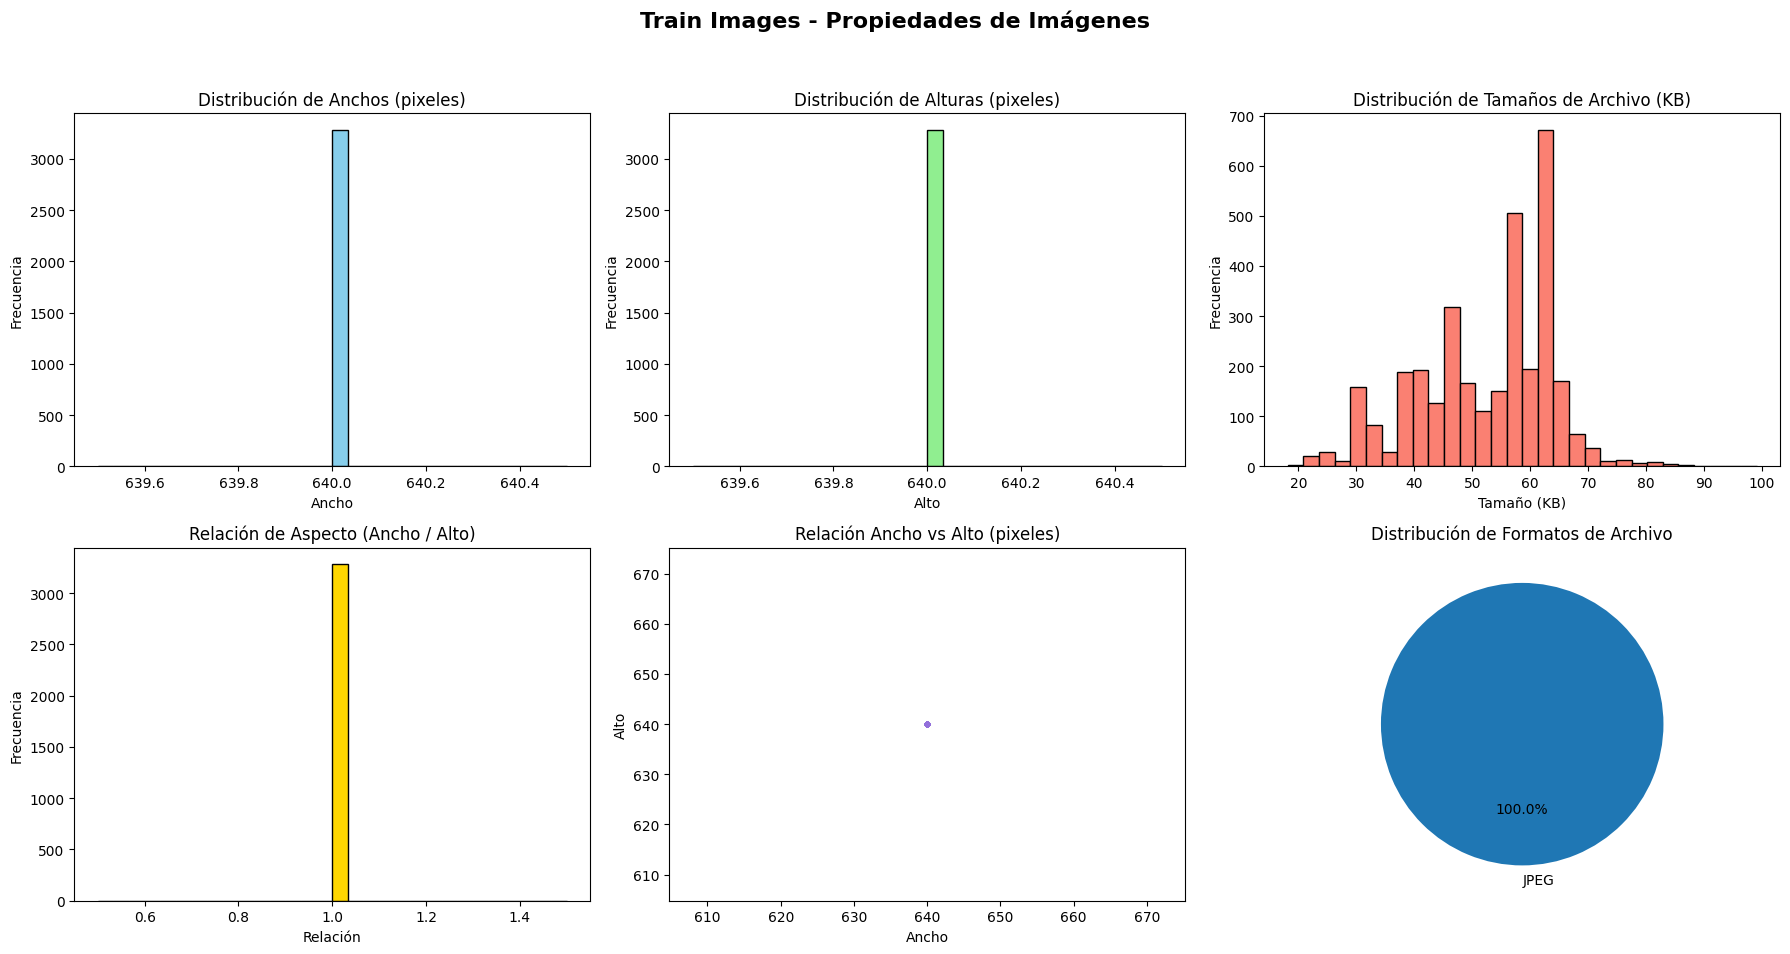

In [57]:
train_images_dir = '/content/Actividades_Unified/train/images'
val_images_dir = '/content/Actividades_Unified/valid/images'
test_images_dir = '/content/Actividades_Unified/test/images'

# Procesar y graficar propiedades de imágenes para cada conjunto
train_image_stats = analyze_image_properties(train_images_dir)
plot_image_properties(train_image_stats, title_prefix="Train Images")



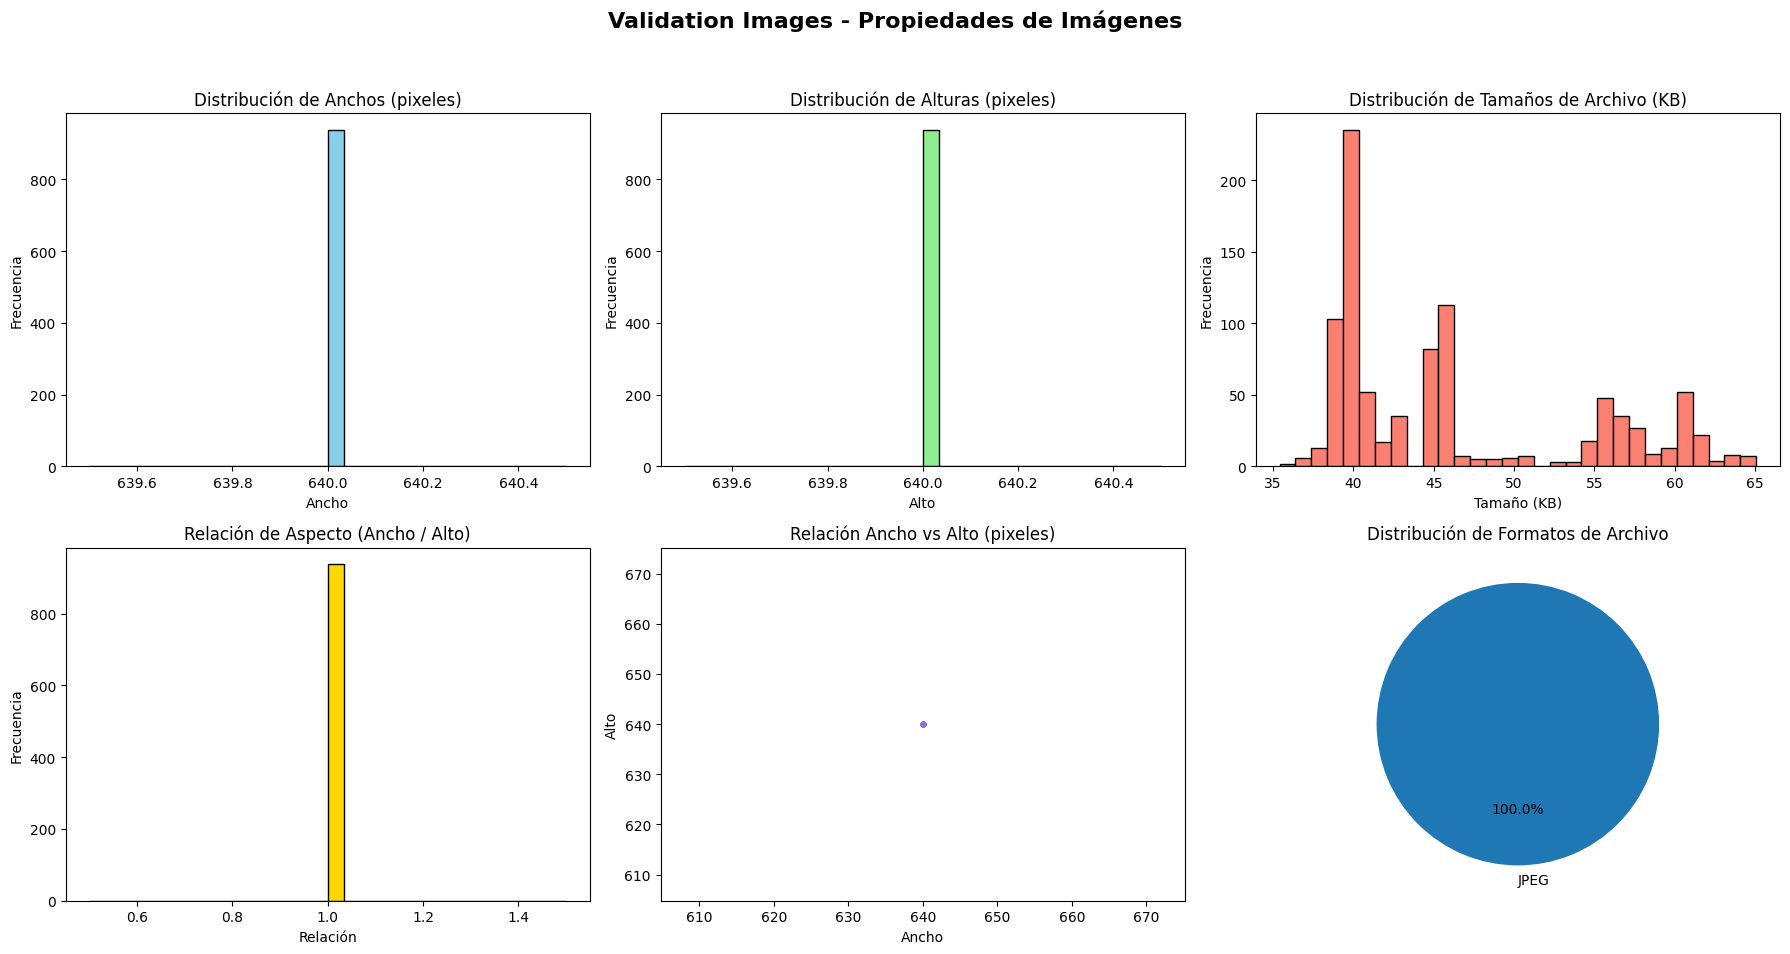

In [58]:
val_image_stats = analyze_image_properties(val_images_dir)
plot_image_properties(val_image_stats, title_prefix="Validation Images")



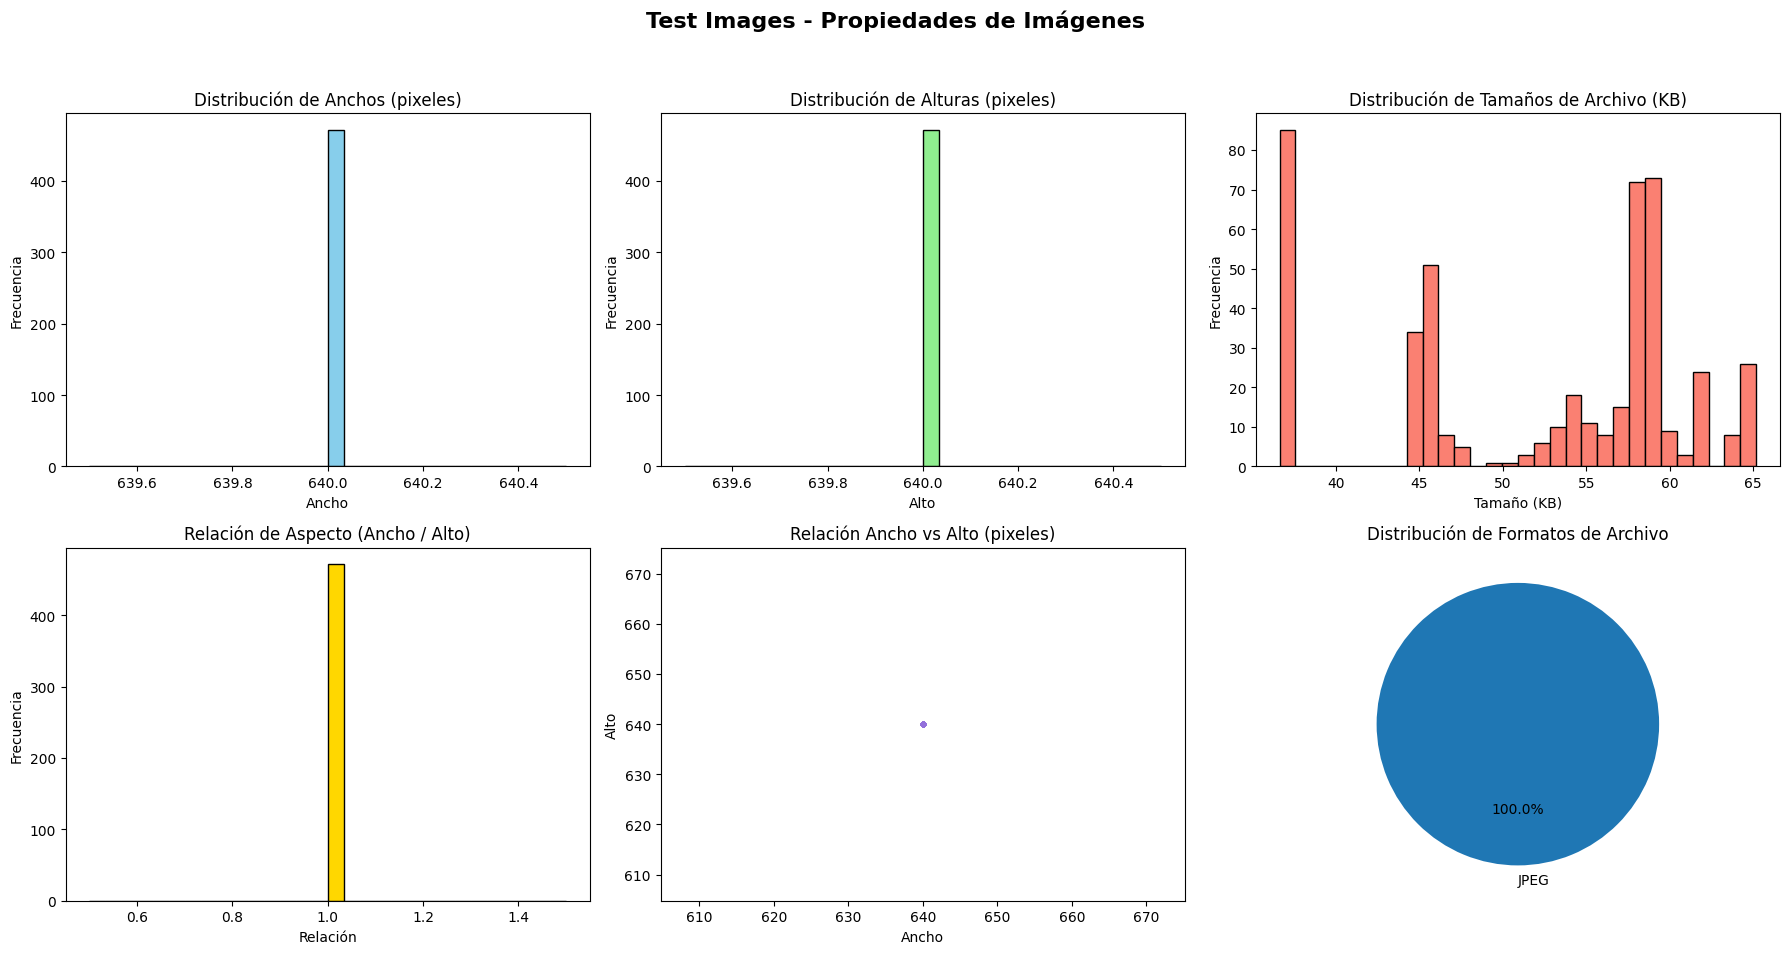

In [59]:
test_image_stats = analyze_image_properties(test_images_dir)
plot_image_properties(test_image_stats, title_prefix="Test Images")

In [64]:
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import numpy as np

def parse_yolo_annotations(label_dir):
    category_counts = Counter()
    bbox_areas = []
    bbox_widths = []
    bbox_heights = []
    image_object_counts = []

    label_files = list(Path(label_dir).glob("*.txt"))

    for file in label_files:
        with open(file, 'r') as f:
            lines = f.readlines()
            image_object_counts.append(len(lines))
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls, x, y, w, h = map(float, parts)
                    category_counts[int(cls)] += 1
                    bbox_areas.append(w * h)
                    bbox_widths.append(w)
                    bbox_heights.append(h)

    return {
        "category_counts": category_counts,
        "bbox_areas": bbox_areas,
        "bbox_widths": bbox_widths,
        "bbox_heights": bbox_heights,
        "objects_per_image": image_object_counts
    }

def plot_annotation_distributions(data, split_name="Train"):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"Distribuciones de Anotaciones - {split_name}", fontsize=16, fontweight='bold')

    # Distribución de clases
    categories = list(data['category_counts'].keys())
    counts = list(data['category_counts'].values())
    axes[0, 0].bar(categories, counts, color='#D7BDE2')
    axes[0, 0].set_title('Distribución de Clases')
    axes[0, 0].set_xlabel('Clase')
    axes[0, 0].set_ylabel('Frecuencia')

    # Distribución de objetos por imagen
    axes[0, 1].hist(data['objects_per_image'], bins=20, color='#A8DADC', edgecolor='black')
    axes[0, 1].set_title('Objetos por Imagen')
    axes[0, 1].set_xlabel('Cantidad de objetos')
    axes[0, 1].set_ylabel('Número de imágenes')

    # Distribución de áreas
    axes[0, 2].hist(data['bbox_areas'], bins=30, color='#B5EAD7', edgecolor='black')
    axes[0, 2].set_title('Distribución de Áreas de Bounding Boxes')
    axes[0, 2].set_xlabel('Área relativa (w*h)')
    axes[0, 2].set_ylabel('Frecuencia')

    # Anchos de bounding boxes
    axes[1, 0].hist(data['bbox_widths'], bins=30, color='skyblue', edgecolor='black')
    axes[1, 0].set_title('Distribución de Anchos de Bounding Boxes')
    axes[1, 0].set_xlabel('Ancho')
    axes[1, 0].set_ylabel('Frecuencia')

    # Altos de bounding boxes
    axes[1, 1].hist(data['bbox_heights'], bins=30, color='#FFF3B0', edgecolor='black')
    axes[1, 1].set_title('Distribución de Altos de Bounding Boxes')
    axes[1, 1].set_xlabel('Alto')
    axes[1, 1].set_ylabel('Frecuencia')

    # Relación de aspecto
    if data['bbox_widths'] and data['bbox_heights']:
        aspect_ratios = np.array(data['bbox_widths']) / np.array(data['bbox_heights'])
        axes[1, 2].hist(aspect_ratios, bins=30, color='#FFB5E8', edgecolor='black')
        axes[1, 2].set_title('Relación de Aspecto (Ancho / Alto)')
        axes[1, 2].set_xlabel('Relación de aspecto')
        axes[1, 2].set_ylabel('Frecuencia')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


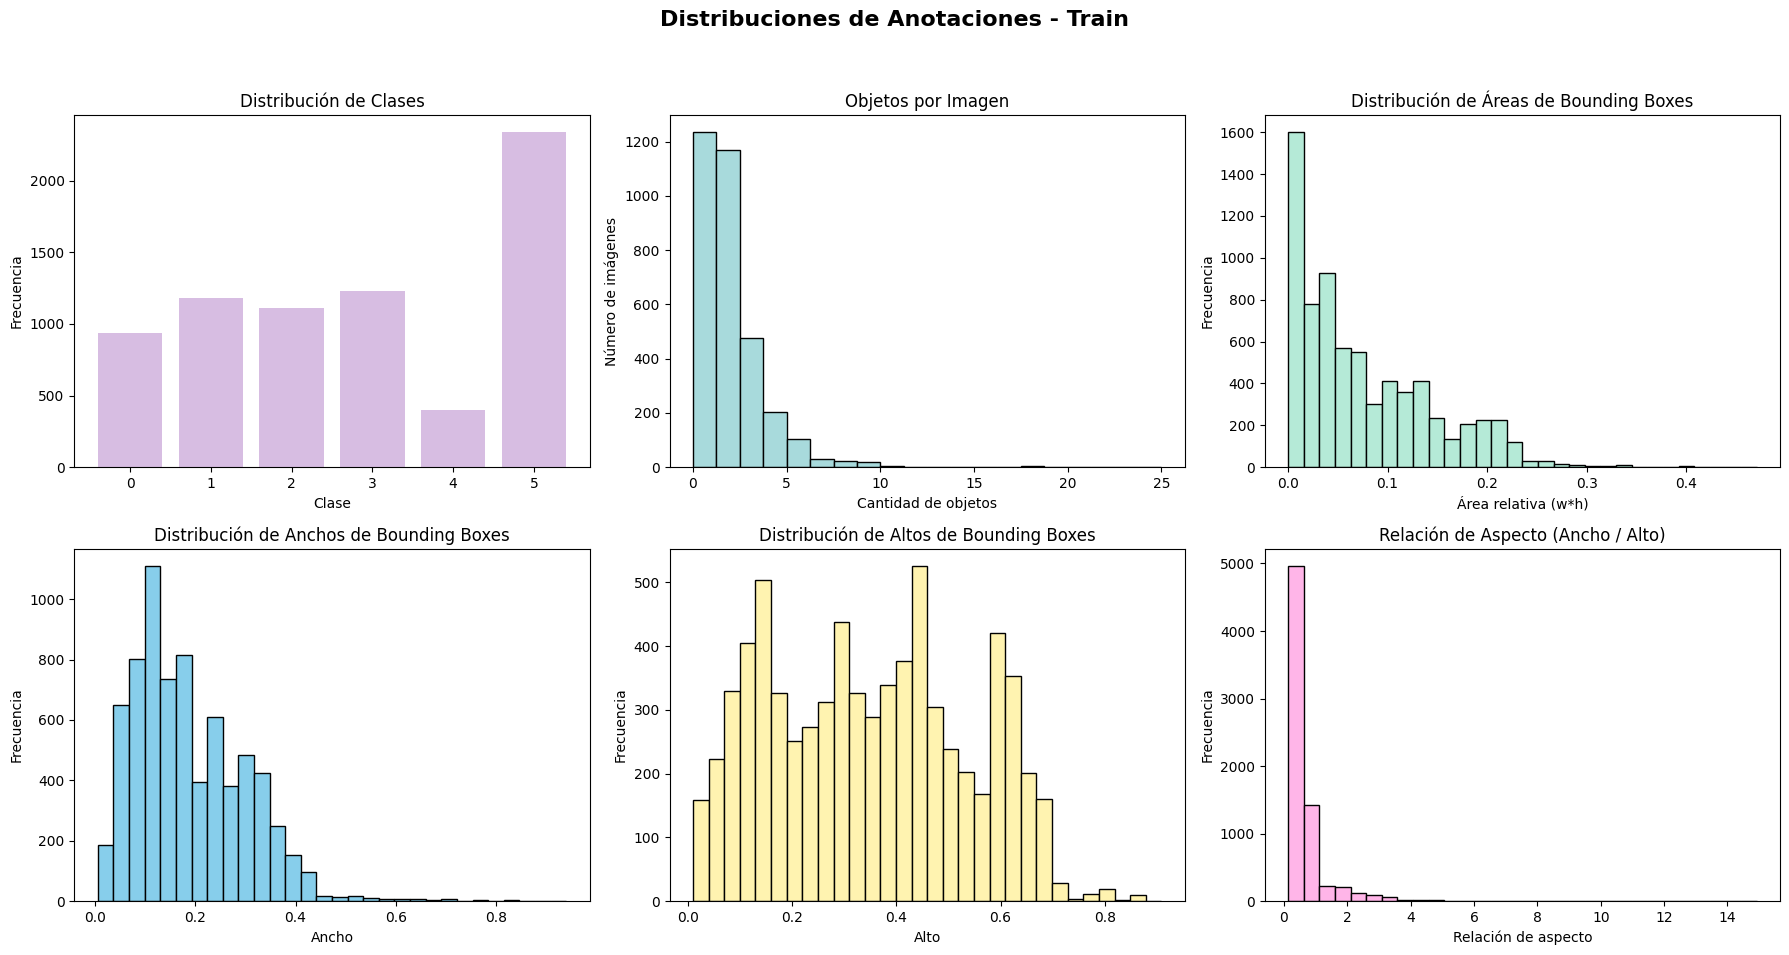

In [65]:
# Define tus rutas a las etiquetas
train_labels = '/content/Actividades_Unified/train/labels'
val_labels = '/content/Actividades_Unified/valid/labels'
test_labels = '/content/Actividades_Unified/test/labels'

# Procesar y graficar para cada conjunto
train_data = parse_yolo_annotations(train_labels)
plot_annotation_distributions(train_data, split_name="Train")



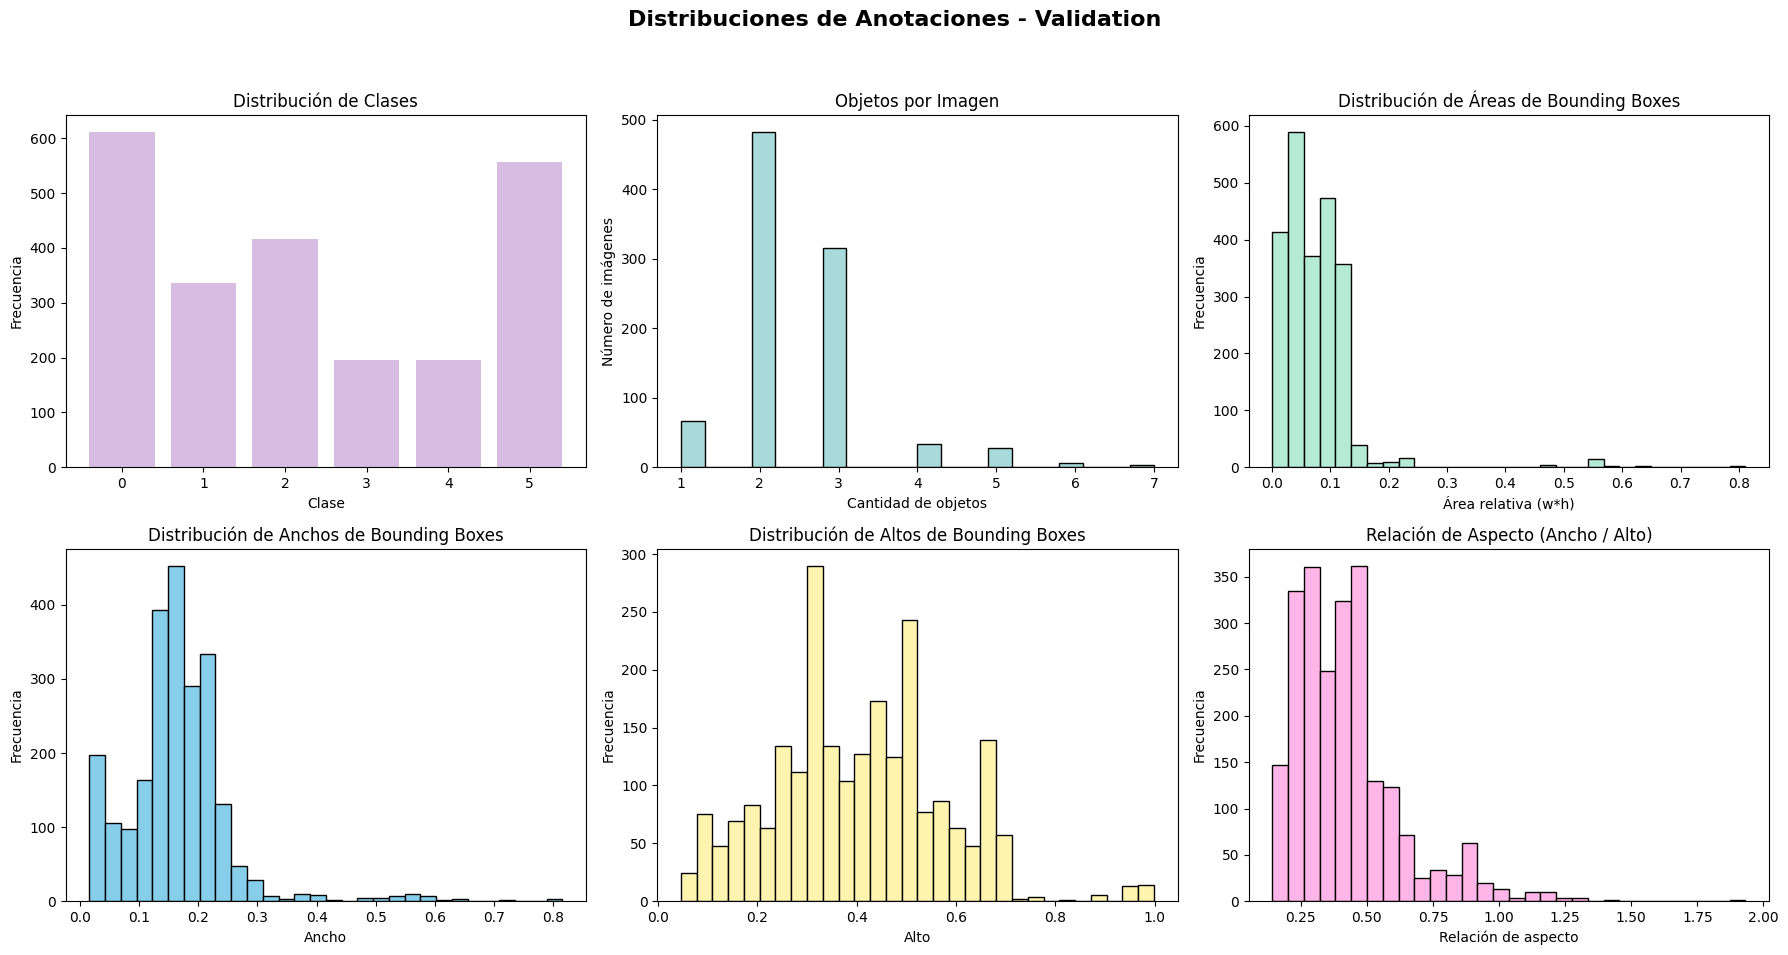

In [66]:
val_data = parse_yolo_annotations(val_labels)
plot_annotation_distributions(val_data, split_name="Validation")



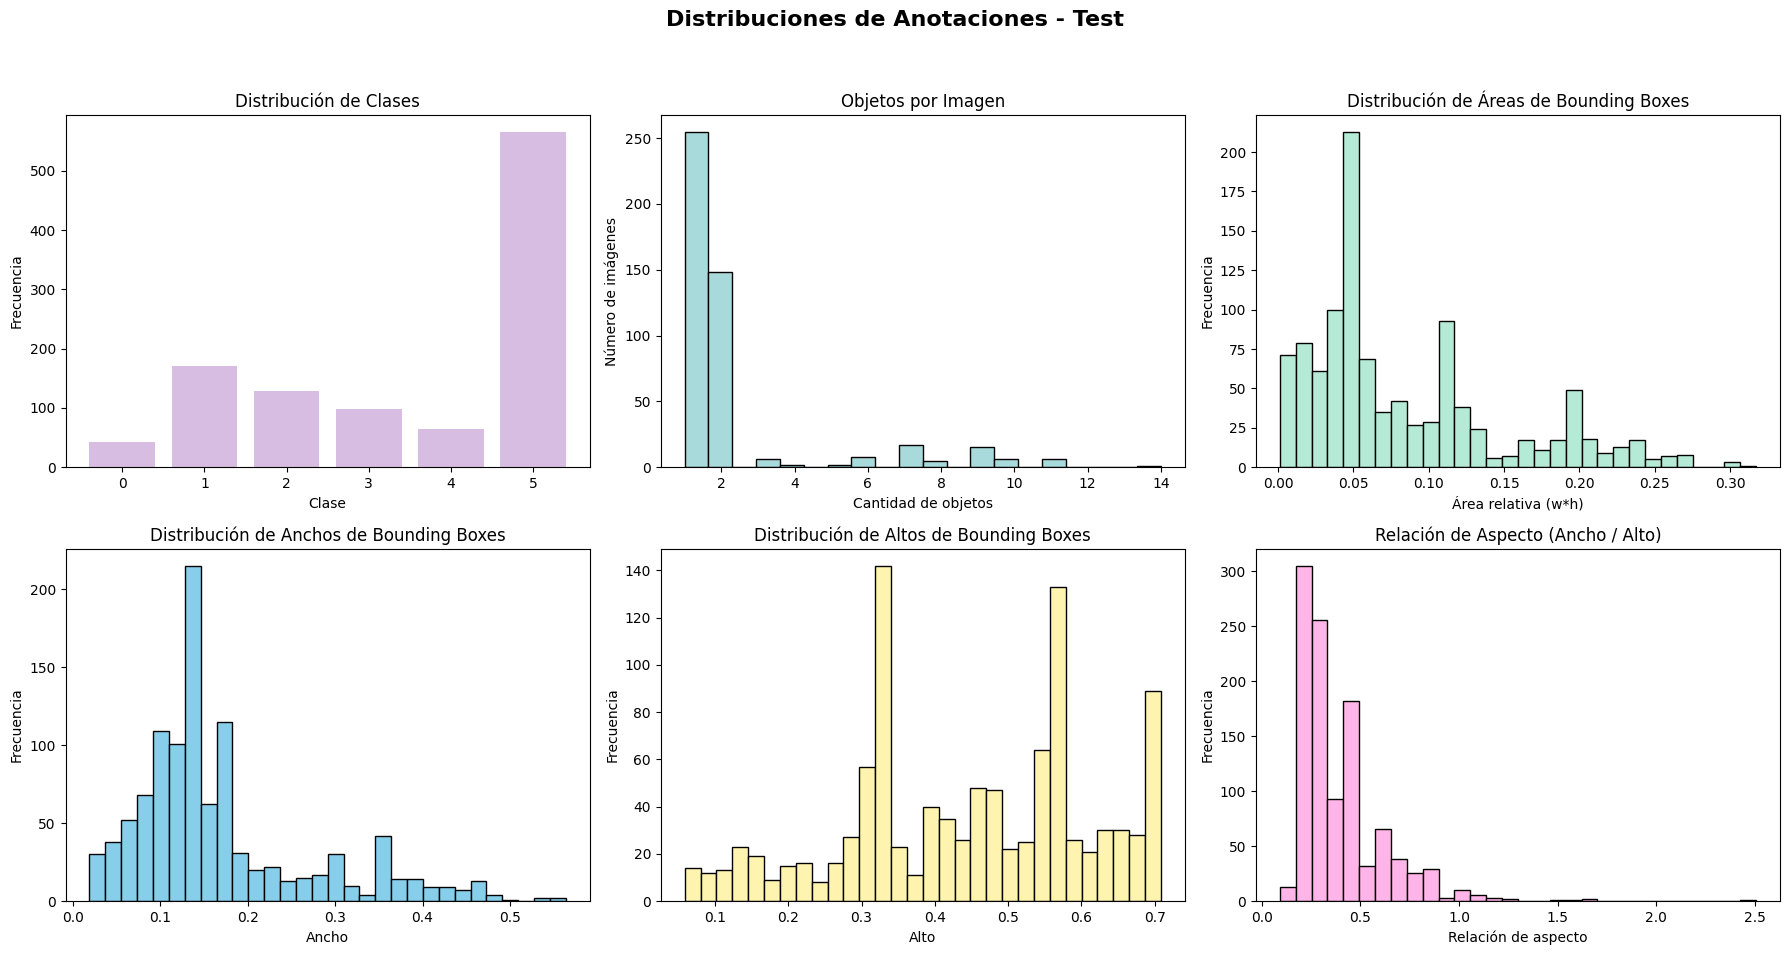

In [67]:
test_data = parse_yolo_annotations(test_labels)
plot_annotation_distributions(test_data, split_name="Test")

In [82]:
import os
import numpy as np
from pathlib import Path

def summarize_stats(data):
    """Devuelve estadísticas básicas (min, max, mean) de una lista numérica"""
    return {
        'min': int(np.min(data)) if len(data) > 0 else 0,
        'max': int(np.max(data)) if len(data) > 0 else 0,
        'mean': float(np.mean(data)) if len(data) > 0 else 0
    }

def create_eda_report(train_img_stats, val_img_stats, test_img_stats,
                      train_ann_stats, val_ann_stats, test_ann_stats,
                      results_dir="eda_resultados"):

    os.makedirs(results_dir, exist_ok=True)
    report = []
    report.append("📊 REPORTE DE ANÁLISIS EXPLORATORIO DE DATOS\n")

    def summarize_split(img_stats, ann_stats, nombre):
        report.append(f"\n🔹 {nombre.upper()}")
        total_imgs = len(img_stats['widths'])
        report.append(f"  - Total de imágenes: {total_imgs}")

        if total_imgs > 0:
            width_stats = summarize_stats(img_stats['widths'])
            height_stats = summarize_stats(img_stats['heights'])
            file_stats = summarize_stats(img_stats['file_sizes'])

            report.append(f"  - Dimensiones promedio: {width_stats['mean']:.0f} x {height_stats['mean']:.0f} píxeles")
            report.append(f"  - Rango de anchos: {width_stats['min']} – {width_stats['max']} px")
            report.append(f"  - Rango de alturas: {height_stats['min']} – {height_stats['max']} px")
            report.append(f"  - Tamaño promedio archivo: {file_stats['mean']:.1f} KB")

        if ann_stats:
            total_ann = sum(ann_stats['category_counts'].values())
            num_clases = len(ann_stats['category_counts'])
            objects_per_img_stats = summarize_stats(ann_stats['objects_per_image'])
            width_bbox_stats = summarize_stats(ann_stats['bbox_widths'])
            height_bbox_stats = summarize_stats(ann_stats['bbox_heights'])

            # Área = ancho * alto
            areas = np.array(ann_stats['bbox_widths']) * np.array(ann_stats['bbox_heights'])
            area_bbox_stats = summarize_stats(areas)

            report.append(f"  - Total anotaciones: {total_ann}")
            report.append(f"  - Número de clases: {num_clases}")
            report.append(f"  - Objetos promedio por imagen: {objects_per_img_stats['mean']:.1f}")
            report.append(f"  - Rango de objetos por imagen: {objects_per_img_stats['min']} – {objects_per_img_stats['max']}")
            report.append(f"  - Área promedio de bounding box: {area_bbox_stats['mean']:.4f} (relativo)")
            report.append(f"  - Dimensiones promedio bbox: {width_bbox_stats['mean']:.3f} x {height_bbox_stats['mean']:.3f}")

            # Distribución de clases
            report.append(f"  - Distribución de clases:")
            for cls_id, count in ann_stats['category_counts'].items():
                percent = (count / total_ann) * 100 if total_ann else 0
                report.append(f"      Clase {cls_id}: {count} instancias ({percent:.1f}%)")

    # Generar el reporte para train/val/test
    summarize_split(train_img_stats, train_ann_stats, "Entrenamiento")
    summarize_split(val_img_stats, val_ann_stats, "Validación")
    summarize_split(test_img_stats, test_ann_stats, "Test")

    # Guardar
    report_text = '\n'.join(report)
    output_path = Path(results_dir) / 'reporte_eda.txt'
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(report_text)

    print(report_text)


In [83]:
train_image_stats = analyze_image_properties(train_images_dir)
val_image_stats = analyze_image_properties(val_images_dir)
test_image_stats = analyze_image_properties(test_images_dir)

train_data = parse_yolo_annotations(train_labels)
val_data = parse_yolo_annotations(val_labels)
test_data = parse_yolo_annotations(test_labels)

In [84]:
create_eda_report(
    train_image_stats, val_image_stats, test_image_stats,
    train_data, val_data, test_data
)

📊 REPORTE DE ANÁLISIS EXPLORATORIO DE DATOS


🔹 ENTRENAMIENTO
  - Total de imágenes: 3279
  - Dimensiones promedio: 640 x 640 píxeles
  - Rango de anchos: 640 – 640 px
  - Rango de alturas: 640 – 640 px
  - Tamaño promedio archivo: 52.5 KB
  - Total anotaciones: 7201
  - Número de clases: 6
  - Objetos promedio por imagen: 2.2
  - Rango de objetos por imagen: 0 – 25
  - Área promedio de bounding box: 0.0773 (relativo)
  - Dimensiones promedio bbox: 0.189 x 0.349
  - Distribución de clases:
      Clase 5: 2343 instancias (32.5%)
      Clase 4: 397 instancias (5.5%)
      Clase 3: 1229 instancias (17.1%)
      Clase 2: 1109 instancias (15.4%)
      Clase 1: 1184 instancias (16.4%)
      Clase 0: 939 instancias (13.0%)

🔹 VALIDACIÓN
  - Total de imágenes: 937
  - Dimensiones promedio: 640 x 640 píxeles
  - Rango de anchos: 640 – 640 px
  - Rango de alturas: 640 – 640 px
  - Tamaño promedio archivo: 46.3 KB
  - Total anotaciones: 2314
  - Número de clases: 6
  - Objetos promedio por imagen